In [1]:
from tf_pwa.config_loader import ConfigLoader
from tf_pwa.amp.core import Particle
import extra_amp
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

2025-09-18 12:27:19.706174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-18 12:27:19.707615: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 12:27:19.773535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-18 12:27:21.771545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

No module named 'uproot' you should install `uproot` correctly for using this module


In [5]:
# Loading config files
config = ConfigLoader("config_a.yml")
config.set_params("final_params.json")

# Sampling four-vectors
p4 = config.generate_phsp_p(1000000) # <-- number of sampled four-vectors
data = config.data.cal_angle(p4)
data["c"] = -np.ones((1000000,))

/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/config_loader/config_loader.py:1035: UserWarning: Neglect ['X(3872)_mass', 'X(3872)_width', 'chi(c2)(3930)_mass', 'chi(c2)(3930)_width', 'Psi(4040)_mass', 'Psi(4040)_width', 'X0(2900)_mass', 'X0(2900)_width', 'X1(2900)_mass', 'X1(2900)_width'] when setting params.
  warnings.warn(


In [44]:
# Which resonances
count = 0
for i in range(len(dg.chains)):
    print(count, ':', dg.chains[i][0])
    count += 1

0 : Bp->X(3872)+K
1 : Bp->X(3915)(0-)+K
2 : Bp->chi(c2)(3930)+K
3 : Bp->X(3940)(1+)+K
4 : Bp->X(3993)+K
5 : Bp->Psi(4040)+K
6 : Bp->X(4300)+K
7 : Bp->NR(0-)SPp+K
8 : Bp->NR(1+)PSp+K
9 : Bp->NR(0-)SPm+K
10 : Bp->NR(1-)PPm+K
11 : Bp->X0(2900)+Dst
12 : Bp->X1(2900)+Dst


In [2]:
paper = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # [0, 1, 3, 4, 7, 8, 12, 15, 18, 19, 20, 21, 22, 23, 24, 25]

res_names = ["X(3872)","X(3915)(0-)","chi(c2)(3930)","X(3940)(1+)","X(3993)","Psi(4040)","X(4300)","NR(0-)SPp","NR(1+)PSp","NR(0-)SPm","NR(1-)PPm","X0(2900)","X1(2900)"]

In [9]:
# Included resonance number(s)
R = paper # [0]: X(3872), [1]: X(3915), [2]: chi(c2)(3930), ..., [0,1]: X(3872) and X(3915), ...

# Modifying model
amp_model = config.get_amplitude()
dg = amp_model.decay_group
dg.set_used_chains(R)

# Executing amplitude calculation
amps = dg.get_amp(data).numpy()

# Which decays
for i in R:
    print(dg[i])
print()

# Which end products
print(p4.keys())

[Bp->X(3872)+K, X(3872)->Dst+D, Dst->D0+pi]
[Bp->X(3915)(0-)+K, X(3915)(0-)->Dst+D, Dst->D0+pi]
[Bp->chi(c2)(3930)+K, chi(c2)(3930)->Dst+D, Dst->D0+pi]
[Bp->X(3940)(1+)+K, X(3940)(1+)->Dst+D, Dst->D0+pi]
[Bp->X(3993)+K, X(3993)->Dst+D, Dst->D0+pi]
[Bp->Psi(4040)+K, Psi(4040)->Dst+D, Dst->D0+pi]
[Bp->X(4300)+K, X(4300)->Dst+D, Dst->D0+pi]
[Bp->NR(0-)SPp+K, NR(0-)SPp->Dst+D, Dst->D0+pi]
[Bp->NR(1+)PSp+K, NR(1+)PSp->Dst+D, Dst->D0+pi]
[Bp->NR(0-)SPm+K, NR(0-)SPm->Dst+D, Dst->D0+pi]
[Bp->NR(1-)PPm+K, NR(1-)PPm->Dst+D, Dst->D0+pi]
[Bp->X0(2900)+Dst, X0(2900)->D+K, Dst->D0+pi]
[Bp->X1(2900)+Dst, X1(2900)->D+K, Dst->D0+pi]

dict_keys([D, D0, K, pi])


In [10]:
# Filling JSON file with amplitudes
all_amps = []

for i in range(len(dg.chains)):
    amp_model = config.get_amplitude()
    dg = amp_model.decay_group

    dg.set_used_chains([i])

    amps = dg.get_amp(data).numpy().flatten()

    amps_sep = []
    for j in amps:
        amps_sep.append([float(j.real), float(j.imag)])

    all_amps.append(amps_sep)

with open('all_amps.json', 'w') as f:
    json.dump(all_amps, f, indent=2)

In [177]:
# Simulating individual and compined complex amplitudes
ind_amps = []

for i in range(len(dg.chains)):
    amp_model = config.get_amplitude()
    dg = amp_model.decay_group

    dg.set_used_chains([i])

    amps = dg.get_amp(data).numpy().flatten()

    ind_amps.append(amps)



amp_model = config.get_amplitude()
dg = amp_model.decay_group
dg.set_used_chains(paper)

tot_amps = dg.get_amp(data).numpy().flatten()

In [19]:
res_names_paper = ["EFF(1++)","eta(c)(3945)","chi(c2)(3930)","h(c)(4000)","chi(c1)(4010)","Psi(4040)","h(c)(4300)","NR(0-+)","NR(1++)","NR(0--)","NR(1--)","T*(cs0)(2870)","T*(cs1)(2900)"]

In [179]:
FF = []

tot = 0
for e in range(len(tot_amps)):
    tot += np.abs(tot_amps[e])**2


for res in range(len(ind_amps)):
    ind = 0
    for e in range(len(tot_amps)):
        ind += np.abs(ind_amps[res][e])**2

    FF.append(ind/tot)

In [180]:
for i in range(len(ind_amps)):
    print(res_names_paper[i], np.round(FF[i]*100,1))

EFF(1++) 10.8
eta(c)(3945) 3.4
chi(c2)(3930) 1.8
h(c)(4000) 5.1
chi(c1)(4010) 10.0
Psi(4040) 2.8
h(c)(4300) 1.2
NR(0-+) 15.9
NR(1++) 17.7
NR(0--) 1.2
NR(1--) 20.4
T*(cs0)(2870) 6.5
T*(cs1)(2900) 5.5


In [12]:
# Dalitz plot
def inv_mass_squared(p1, p2):
    E = p1[:, 0] + p2[:, 0]
    px = p1[:, 1] + p2[:, 1] 
    py = p1[:, 2] + p2[:, 2]
    pz = p1[:, 3] + p2[:, 3]
    return E**2 - (px**2 + py**2 + pz**2)

p4_str = {str(k): v for k, v in p4.items()}


I = np.abs(amps)**2
I = I.flatten()

p_D, p_D0, p_K, p_pi = p4_str['D'], p4_str['D0'], p4_str['K'], p4_str['pi']

p_Dst = p_D0 + p_pi

m2_DstD = inv_mass_squared(p_Dst, p_D)
m2_DstK = inv_mass_squared(p_Dst, p_K)
m2_DK = inv_mass_squared(p_D, p_K)

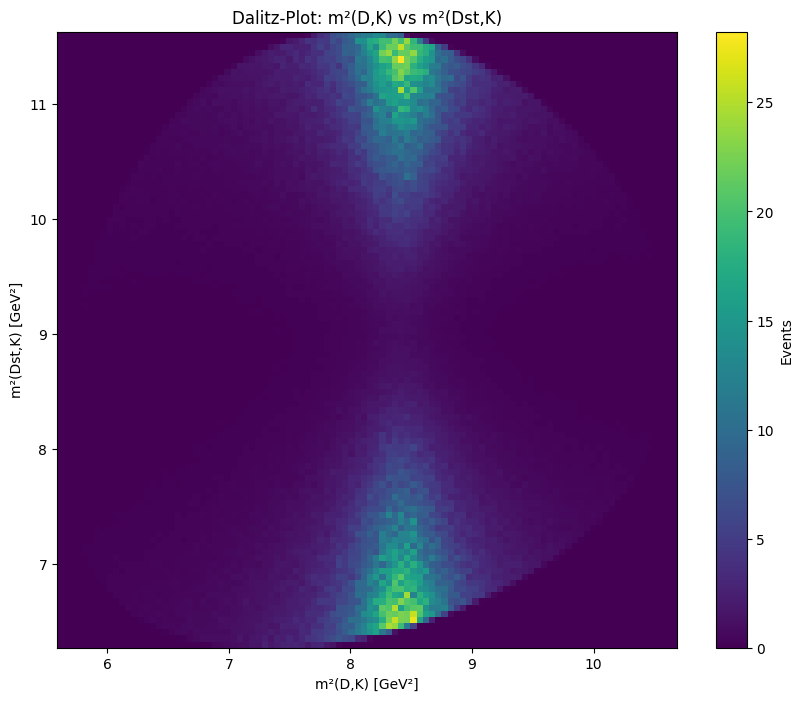

In [23]:
plt.figure(figsize=(10, 8))
plt.hist2d(m2_DK, m2_DstK, bins=100, weights=I, cmap='viridis')
plt.colorbar(label='Events')
plt.xlabel('m²(D,K) [GeV²]')
plt.ylabel('m²(Dst,K) [GeV²]')
plt.title('Dalitz-Plot: m²(D,K) vs m²(Dst,K)')
plt.show()

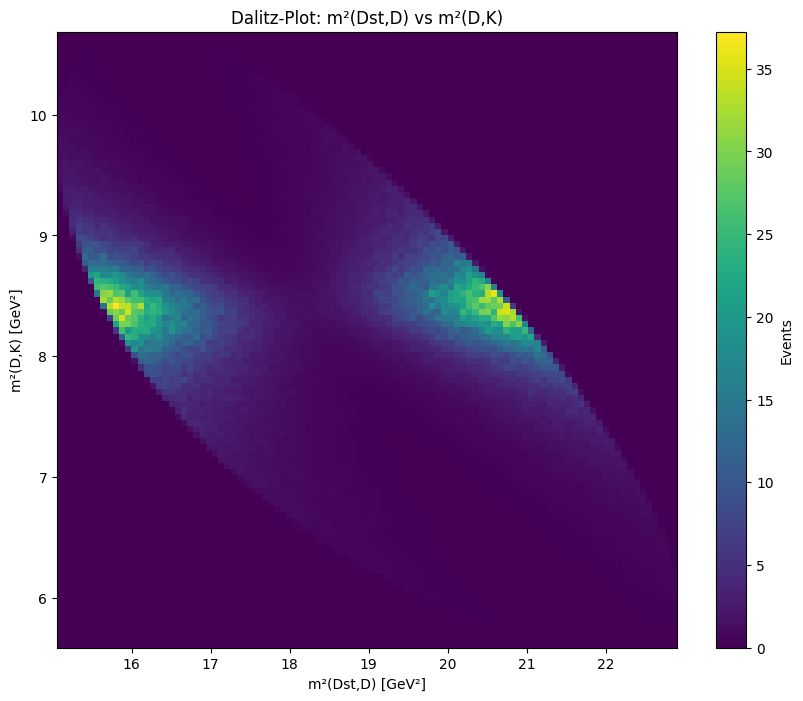

In [24]:
plt.figure(figsize=(10, 8))
plt.hist2d(m2_DstD, m2_DK, bins=100, weights=I, cmap='viridis')
plt.colorbar(label='Events')
plt.xlabel('m²(Dst,D) [GeV²]')
plt.ylabel('m²(D,K) [GeV²]')
plt.title('Dalitz-Plot: m²(Dst,D) vs m²(D,K)')
plt.show()

/tmp/ipykernel_497937/2614432405.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("plasma", n_resonances)


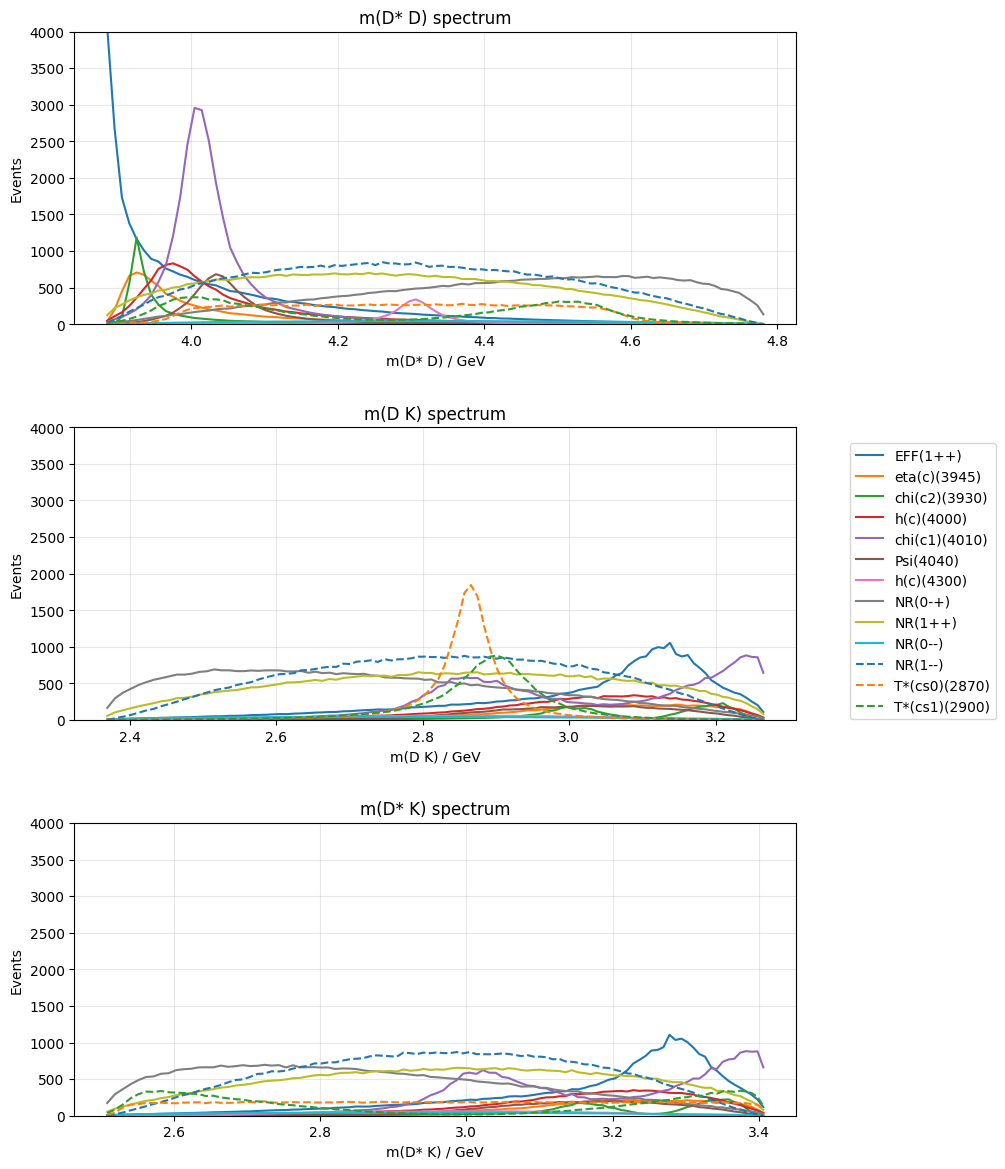

In [25]:
# Plotting of all mass spectra

n_resonances = len(paper)
n_events = len(all_amps[0])

amps_array = np.zeros((n_resonances, n_events), dtype=np.complex128)

for i in paper:
    for j in range(n_events):
        re, im = all_amps[i][j]
        amps_array[paper.index(i), j] = re + 1j*im

weights = np.abs(amps_array)**2

m = [m2_DstD, m2_DK, m2_DstK]
m_names = ["m(D* D)", "m(D K)", "m(D* K)"]
lims = [4000, 4000, 4000]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
plt.subplots_adjust(hspace=0)

cmap = plt.cm.get_cmap("plasma", n_resonances)
colors = [cmap(i) for i in range(n_resonances)]

handles, labels = [], []

for M in range(len(m)):
    ax = axes[M]
    Hist = []
    
    for res in range(len(weights)):
        hist, edges = np.histogram(m[M], bins=100, weights=weights[res])
        Hist.append(hist)
        bin_centers = np.sqrt(0.5*(edges[1:] + edges[:-1]))
        
        if res < 10:
            line = ax.plot(bin_centers, hist, label=res_names_corrected[paper[res]])
        else:
            line = ax.plot(bin_centers, hist, label=res_names_corrected[paper[res]], linestyle="--")
        
        if M == 0:
            handles.extend(line)
            labels.append(res_names_corrected[paper[res]])

    res_sums = []
    for b in range(100):
        sum = 0
        for r in range(n_resonances):
            sum += Hist[r][b]
        
        res_sums.append(sum)

    ax.set_ylim(0, lims[M])
    ax.grid(alpha=0.3)
    ax.set_xlabel(f"{m_names[M]} / GeV")
    ax.set_ylabel("Events")
    ax.set_title(f"{m_names[M]} spectrum")
    ax.set_aspect(0.0001)

fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout(pad=0.5)
plt.show()

In [26]:
for i in range(13):
    print(dg.chains[i][0], f":   {bin_centers[np.argmax(Hist[i])]: .4} GeV   ", np.max(Hist[i]))

Bp->X(3872)+K :    3.277 GeV    1105.7072267914218
Bp->X(3915)(0-)+K :    3.228 GeV    216.89673115203738
Bp->chi(c2)(3930)+K :    3.358 GeV    223.9399286435518
Bp->X(3940)(1+)+K :    3.228 GeV    349.3506625793377
Bp->X(3993)+K :    3.382 GeV    882.3489527348042
Bp->Psi(4040)+K :    3.178 GeV    198.5820760442247
Bp->X(4300)+K :    2.987 GeV    63.37133825689921
Bp->NR(0-)SPp+K :    2.724 GeV    695.2862723011335
Bp->NR(1+)PSp+K :    2.987 GeV    655.4170010928327
Bp->NR(0-)SPm+K :    2.849 GeV    43.05939867426975
Bp->NR(1-)PPm+K :    3.005 GeV    870.3385842136429
Bp->X0(2900)+Dst :    2.724 GeV    196.71106287296467
Bp->X1(2900)+Dst :    3.374 GeV    341.770843365779
